# Data Science Project

* Name: Author Name
* Email:


## TABLE OF CONTENTS 


- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

> Explain the point of your project and what question you are trying to answer with your modeling.



# OBTAIN

## Imports and Functions

In [113]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels
import statsmodels.tsa.api as tsa
import plotly.express as px
import plotly.io as pio
import math
from math import sqrt
import holidays

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


import pickle
import gzip
import shutil
import os

import csv
from pathlib import Path
import subprocess
import io
from icecream import ic
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

plt.style.use('classic')
%matplotlib inline

In [126]:
def display_csvfileDF(file_name, folder):
    """This function displays a dataframe from a csv file with all the columns names
    Argument:
    file name: a file a name, str
    folder: a name of a sub-folder in data folder the file is resigning in, str"""
    
    df = pd.read_csv('data/'+folder+file_name, header=0, encoding='UTF-8')
    return df

def empty_string_count(df):
    """Function to count empty strings and null values in na dataframe columns
    Arguments:
    df: a dataframe"""
    clmns_list=df.columns
    for clmn in clmns_list:
        num_empty_strng=len(df[df[clmn]==''])
        num_nulls=len(df[df[clmn].isnull()])
        print('Column {} empty string count: {}'.format(clmn,num_empty_strng))
        print('Column {} null values count: {}'.format(clmn,num_nulls))
        print('******************************************************')
    print('Total number of records in the dataframe: {}'.format(len(df)))
    
def check_stationarity(ts, label, window=52, plot=True, index=['Dickey-Fuller test results']):
    """This function plots the rolling mean and the rolling standard deviation os a timeseries and prints out
    the results of a Dickey-Fuller test
    Arguments:
    ts: time-series
    window: rolling window, int, 52 is a default
    label: a label of the timeseries to be displayed in the legend
    index: index is needed to create a dataframe with all scalar values
    plot: a flag to plot the series"""
    
    tsw_sma_mean=ts.rolling(window).mean()
    tsw_sma_std=ts.rolling(window).std()
    
    #Dickey-Fuller test results
    
    stnry_test=adfuller(ts, autolag='AIC')
    dict_results={}
    columns=['T_value','P_value','Lags','Observations',
             'Critical value, 1%','Critical value, 5%','Critical value, 10%','Stationary?']
    values=[stnry_test[0],stnry_test[1],stnry_test[2],stnry_test[3]]
    values_=[]
    for key, value in stnry_test[4].items():
        values_.append(value)
    values_.append(stnry_test[1]<0.05)

    values.extend(values_) 
    dict_results=dict(zip(columns,values))
    df=pd.DataFrame(dict_results, index=index)

    #Plotting
    
    if plot:
        fig, ax = plt.subplots(figsize=(18,6))
        sns.set_context('poster')
        sns.set_style('darkgrid')
        sns.set_context('poster')
        sns.set_style('darkgrid')

        ax.plot(ts.index, ts.values, label=label)
        ax.plot(tsw_sma_mean.index,tsw_sma_mean.values, label='Rolling Mean')
        ax.plot(tsw_sma_std.index,tsw_sma_std.values, label='Standard Deviation')
        title='Rolling Mean and Rolling Standard Deviation, '+str(window)+' week window'
        ax.set_title(title, fontsize=28);
        ax.set_ylabel('Offense Counts', fontsize=22);
        ax.set_xlabel('Year', fontsize=22);
        plt.legend(loc='best');
    return df
        
def decomposing(ts):
    """Function displays decomposition plots of a times-series in a pretty way
    Arguments:
    ts: time-series"""
    matplotlib.rc_file_defaults()

    decomposition=seasonal_decompose(ts)
    fig=plt.figure()
    fig=decomposition.plot()
    fig.set_size_inches(15,10)
    fig.set_facecolor('lightgrey')
    fig.suptitle('Decomposition Plots', fontsize=20, color='r')
    
    
def create_ts_dict(column, df_, freq='W' ):
    """Function to create a dictionary with timeseries of a category in a dataframe:
    Arguments
    column: a column in the dataframe, str
    df_: a dataframe to consider, default=df_full_ts, should be indexed by a timestamp"""
    
    list_categories=df_full_ts[column].unique()
    TS_dict_name={}

    for category in list_categories:
        df=df_full_ts.groupby(column).get_group(category)
        TS_dict_name[category]=df.resample(freq).count()['offense_id'].rename(category)
#        TS_dict_name[category].rename(category)
    return TS_dict_name

def ACF_PACF_multiple(ts_dict):
    """Function to display ACFs and PACFs for time-series in a dictionary"""
    
    for crime, ts in ts_dict.items():
        matplotlib.rc_file_defaults()
        plt.rc("figure", figsize=(10,3))
        fig, axes = plt.subplots(ncols=2)
        plot_acf(ts,title='ACF, '+crime,ax=axes[0])
        plot_pacf(ts,title='PACF, '+crime,ax=axes[1])
        
def check_stationarity_multiple(ts_dict, window=52, plot=True):
    """This function plots the rolling mean and the rolling standard deviation os a timeseries and prints out
    the results of a Dickey-Fuller test for all timeseries in the dictionary
    
    Arguments:
    dict_: dictionary with timeframes
    window: rolling window, int, 52 is a default
    plot: a flag to plot the series or just do the frint out
    
    Output is a df with all the results"""

    
    plt.style.use('classic')
    
    index_list=[]
    for key, value in ts_dict.items():
        index_list.append(key)
    
    dict_test={}
    columns=['Crime Category','Critical Value','P-value','Lags','Observations',
            'Critical value, 1%','Critical value, 5%',
            'Critical value, 10%','Stationary?']
    
    for column in columns:
        dict_test[column]=''
        
    df_results=pd.DataFrame(dict_test, index=['Number'])
        
    dict_stationary={}
    dict_non_stationary_diff={}
    
    for crime, ts in ts_dict.items():
        tsw_sma_mean=ts.rolling(window).mean()
        tsw_sma_std=ts.rolling(window).std()
    
        #Dickey-Fuller test results
        stnry_test=adfuller(ts, autolag='AIC')
        values=[crime, stnry_test[0],stnry_test[1],stnry_test[2], stnry_test[3]]
        values_=[]
        for key, value in stnry_test[4].items():
            values_.append(value)
        values_.append(stnry_test[1]<0.05)
        values.extend(values_)
        
        df_results.loc[len(df_results)] = values

        if values[-1]:
            stationarity='Stationary'
            dict_stationary[crime]=ts
        else:
            stationarity='Non-stationary'
            dict_non_stationary_diff[crime]=ts.diff().dropna()
            
        if plot:
            plt.style.use('classic')
            fig, ax = plt.subplots(figsize=(12,4))
            
            matplotlib.rc_file_defaults()
            matplotlib.rc_file_defaults()
            ax.plot(ts.index, ts.values, label=crime + ', '+stationarity )
            ax.plot(tsw_sma_mean.index,tsw_sma_mean.values, label='Rolling Mean')
            ax.plot(tsw_sma_std.index,tsw_sma_std.values, label='Standard Deviation')
            title= crime+', '+str(window)+' week window'
            ax.set_title(title, fontsize=18);
            ax.set_ylabel('Offense Counts', fontsize=15);
            ax.set_xlabel('Year', fontsize=15);
            plt.legend(loc='best');
            plt.grid()
   
    return df_results, dict_stationary, dict_non_stationary_diff

## Data

### Data source and data description

Data is from FBI Crime Data Explorer
[NIBRS data for Colorado from 2009-2019](https://crime-data-explorer.fr.cloud.gov/pages/downloads)

The [data dictionary](data/NIBRS_DataDictionary.pdf) is  and a [record descriptiopn](data/NIBRS_Record_Description.pdf) are available.


The description of the main and reference tables is in data/README.md file.
The agency implemented some changes to the files structure in 2016 and removed the sqlite create and load scripts from the zip directories.
Another fact worth mentioning is that files 'nibrs_property_desc.csv' from 2014 and 2015 have duplicated nibrs_property_desc_ids (unique identifier in the nibrs_property_desc table) which complicated the loading of the data.

The rest of the original data description is in description is in the [notebook](capstone_prj_scrub_part1.ipynb) with the first part of data pre-processing.

### Using an already created sqlite database

The notebook with database creation is [here](creating_sqlite_db.ipynb). The referenced database is in ***data/sqlite/db/production1 db***. It takes 2.5 minutes to run the database creation script.

# SCRUB

## Part I, pre-processing the data in SQL database

The first part of the scrubbing process (working with sqlite3 database, production1) is in [this notebook](capstone_prj_scrub_part1.ipynb). It takes about 12 minutes to run the code in part1 notebook. The following code is using dataframes created in part I.

In part I the following dataframes have been created and saved in the pickle files:<br>

    1. df_incident: data/pickled_dataframes/incident.pickle; main incident DF with date/time of an incident
    2. df_offense: data/pickled_dataframes/offense.pickle: main offense DF with offense names and categories
    3. df_offender: data/pickled_dataframes/offender.pickle; main offender DF with demographic info
    4. df_victim: data/pickled_dataframes/victim.pickle; main victim DF with demographic info
    5. df_weapon: data/pickled_dataframes/weapon.pickle; main weapon DF with a weapon category used in an offense
    6. df_bias: data/pickled_dataframes/bias.pickle; main bias DF with offense bias motivation
    7. df_rel: data/pickled_dataframes/relationship.pickle; main victim-offender relationship DF with relationship category
    

## Part II, scrubbing the data in DataFrames

<br><br><span style="font-size:1.2em;">The next step is uploading, displaying info and scrubbing the dataframes in [part 2 notebook](capstone_prj_scrub_part2-px.ipynb) </span>

<br><br><span style="font-size:1.2em;"><b>1. Offense, incident, bias and weapon DataFrames are combined into one for the Times-series analysis<br>
2. Offender, victim and relationship DataFrames are set aside for the future dashboard.</b></span><br><br>
<span style="font-size:1.2em;">The cleaned-up dataframes can be found here:</span>

    1. df_incident: data/pickled_dataframes/incident_clean.pickle; main cleaned-up incident DF with date/time of an incident
    2. df_offense: data/pickled_dataframes/offense_clean.pickle: main cleaned-up offense DF with offense names and categories
    3. df_offender: data/pickled_dataframes/offender_clean.pickle; main cleaned-up offender DF with demographic info
    4. df_victim: data/pickled_dataframes/victim_clean.pickle; main cleaned-up victim DF with demographic info
    5. df_weapon: data/pickled_dataframes/weapon_clean.pickle; main cleaned-up weapon DF with a weapon category used in an offense
    6. df_bias: data/pickled_dataframes/bias_clean.pickle; main cleaned-up bias DF with offense bias motivation
    7. df_rel: data/pickled_dataframes/rel_clean.pickle; main cleaned-up victim-offender relationship DF with relationship category
    

### Combining Incident, Offense, Bias and Weapon DataFrames

<br><br><span style="font-size:1.2em;">The cleaned-up FULL dataframes can be found here:</span>

    df_full: 'data/pickled_dataframes/df_full_clean.pickle'; main cleaned-up combined DF for time-series analysis

In [115]:
with open('data/pickled_dataframes/df_full_clean.pickle', 'rb') as f:
    df_full=pickle.load(f)

# EXPLORE

## EDA

<span style="font-size:1.2em; background: lightblue">All EDA part is in the notebook with Part II [part 2 notebook](capstone_prj_scrub_part2-px.ipynb)</span>

<br><br><span style="font-size:1.2em;">The dictionaries with timeseries of varios crime categories and crime locations can be fount here:</span>

    1. TS_crime_categoryt: data/pickled_ts_dict/TS_crime_category.pickle; a dictionary with crime categories and associated time series
    2. TS_crime_against: data/pickled_ts_dict/TS_crime_against.pickle: a dictionary with crime against categories and associated time series
    3. TS_crime_location: data/pickled_ts_dict/TS_crime_location.pickle; a dictionary with crime locations and associated time series
   

# MODEL

## Splitting into a training and a test sets

<br><span style="font-size:1.2em;">I am cutting off a ~33% tail of my data to create a test set.</span><br>

In [116]:
with open('data/pickled_ts/ts_weekly.pickle', 'rb') as f:
    ts_weekly=pickle.load(f)

Observations: 575 weeks
Training Observations: 380 weeks
Testing Observations: 195 weeks


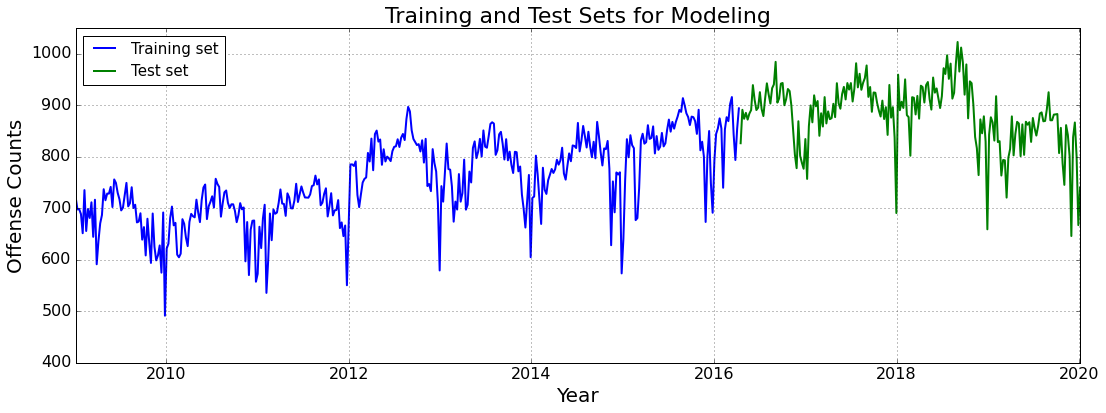

In [117]:
train_size = round(len(ts_weekly) * 0.66)
ts_train, ts_test = ts_weekly[:train_size], ts_weekly[train_size:]
print('Observations: %d weeks' % (len(ts_weekly)))
print('Training Observations: %d weeks' % (len(ts_train)))
print('Testing Observations: %d weeks' % (len(ts_test)))


fig, ax = plt.subplots(figsize=(18,6))

ax.plot(ts_train.index, ts_train.values, label='Training set', lw=2)
ax.plot(ts_test.index,ts_test.values, label='Test set', lw=2)

ax.set_title('Training and Test Sets for Modeling', fontsize=22);
ax.set_ylabel('Offense Counts', fontsize=20);
ax.set_xlabel('Year', fontsize=20);
ax.set_ylim(400, 1050);
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.grid()
plt.legend(loc='upper left', fontsize=15);
plt.show()

## General Crime Rate Modeling

<span style="font-size:1.2em; background: lightblue">All modeling of General Crime rate is in the notebook with Part II [part 2 notebook](capstone_prj_scrub_part2-px.ipynb)</span>

## Crime Rate per Offense Category Modeling

### Loading the dictionaries with time-series

In [118]:
with open('data/pickled_ts/TS_crime_category.pickle', 'rb') as f:
    TS_crime_category=pickle.load(f)
    
with open('data/pickled_ts/TS_crime_against.pickle', 'rb') as f:
    TS_crime_against=pickle.load(f)
        
with open('data/pickled_ts/TS_crime_location.pickle', 'rb') as f:
    TS_crime_location=pickle.load(f)

### Checking for stationarity

#### Checking the stationarity of the time-series in Offense category dictionary

<ipython-input-114-ab24c4f1bfc4>:165: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,4))


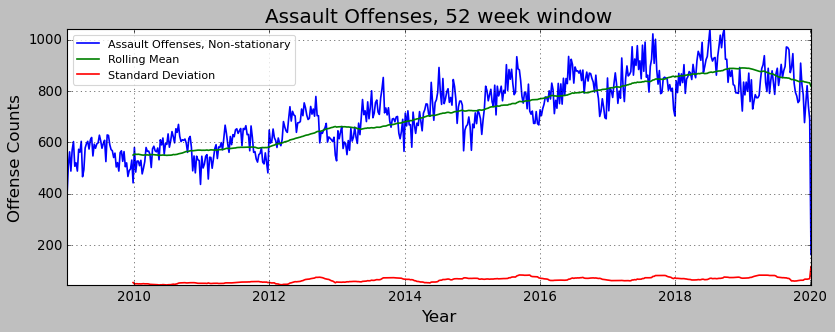

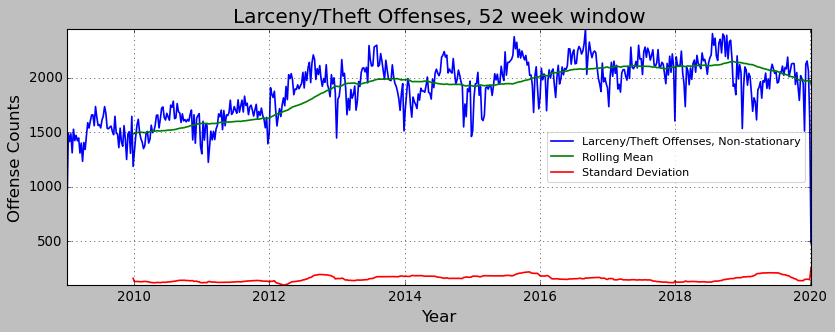

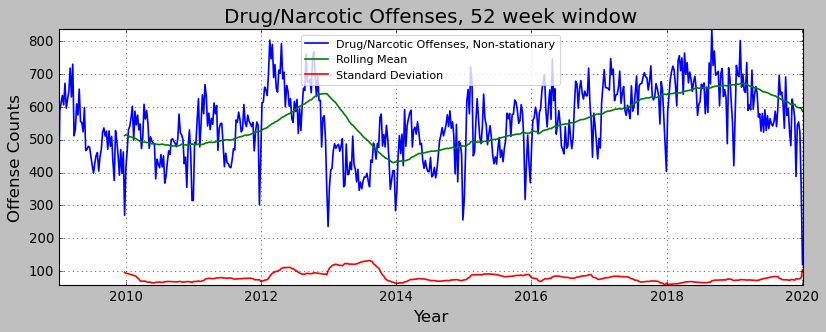

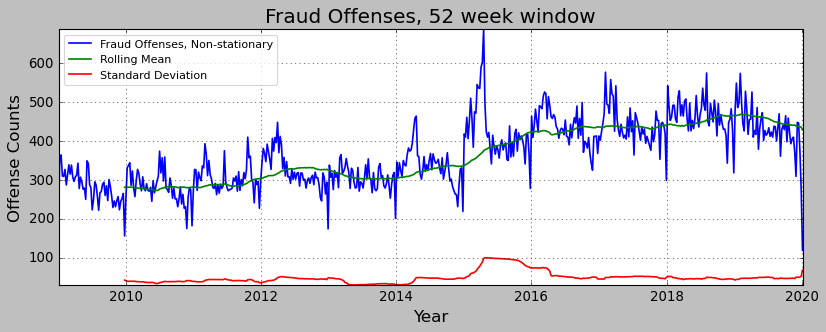

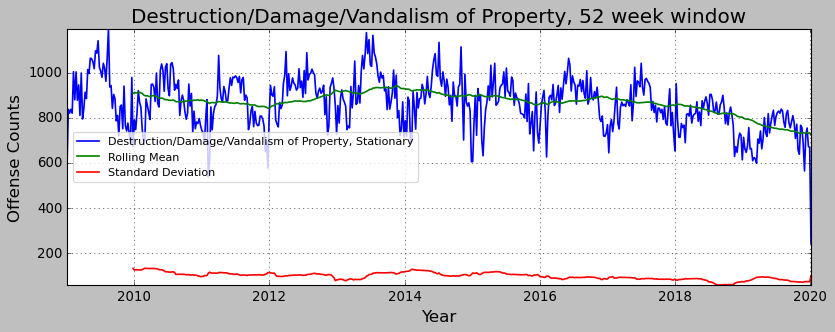

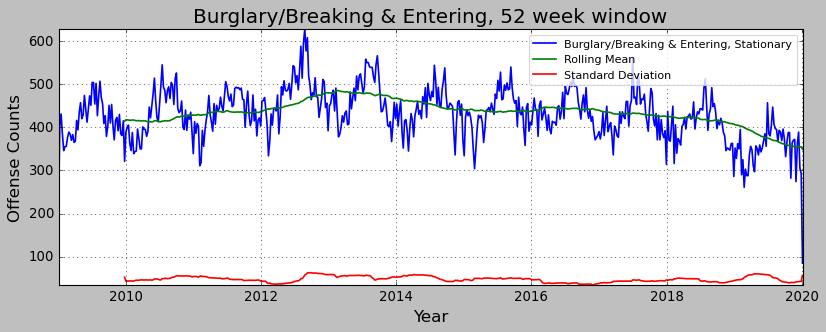

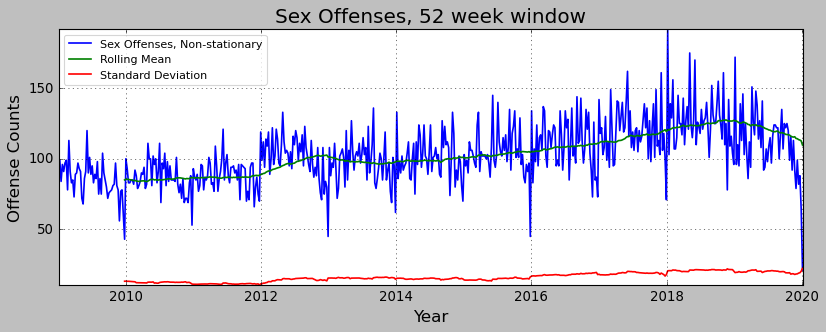

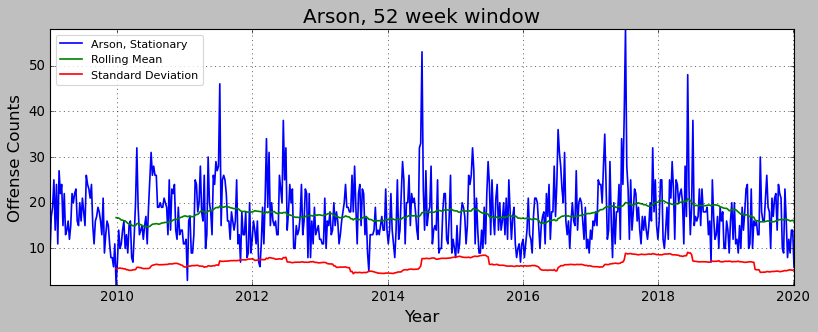

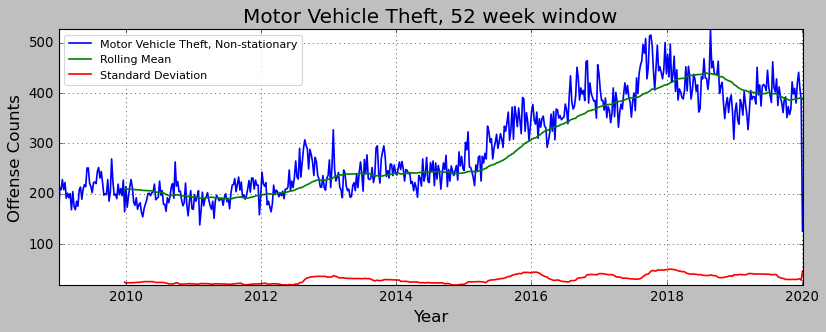

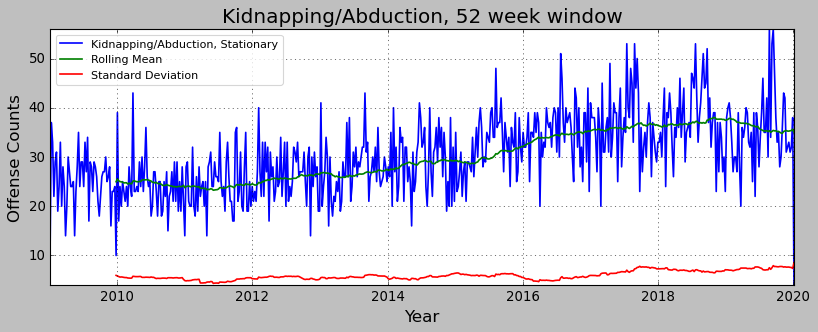

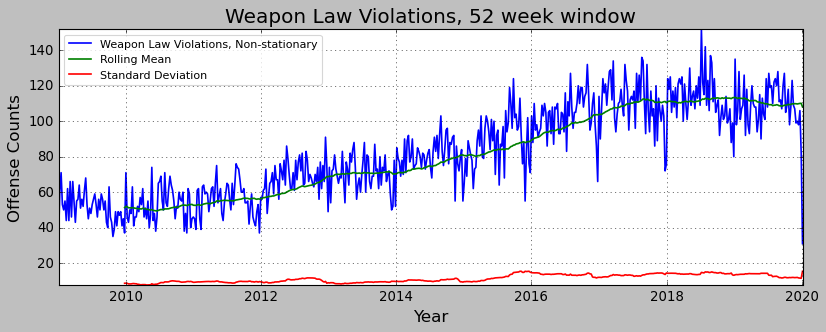

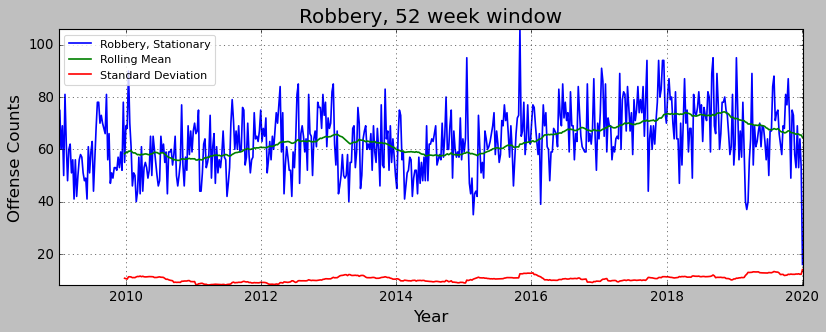

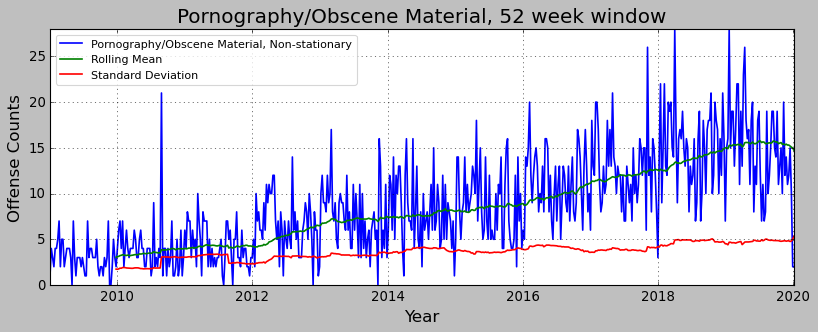

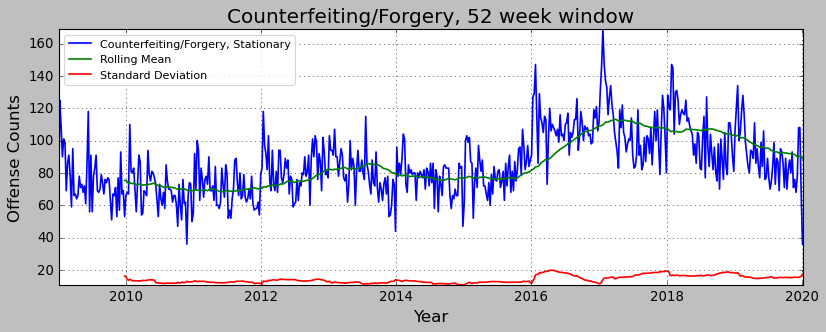

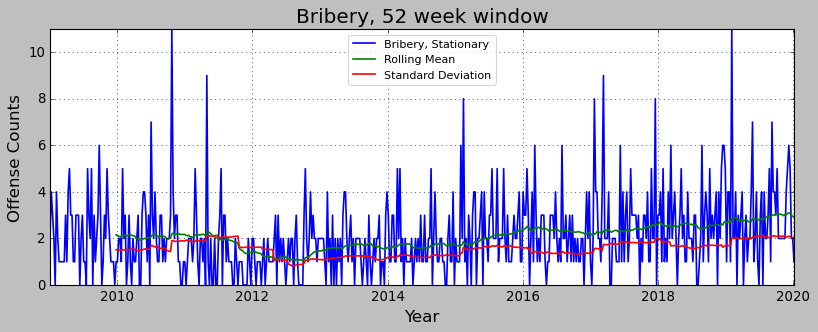

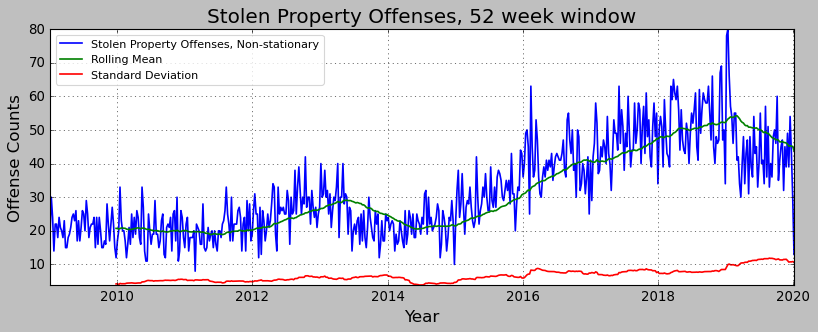

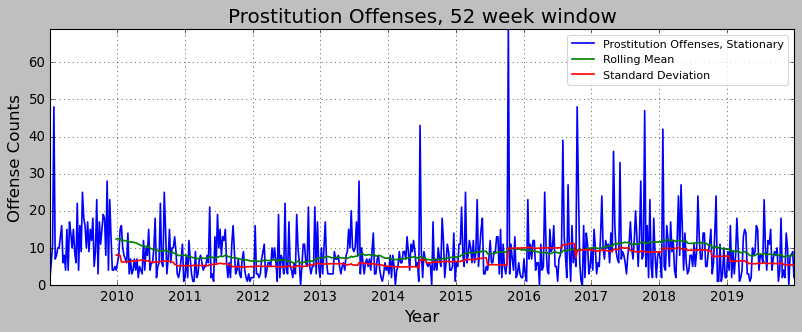

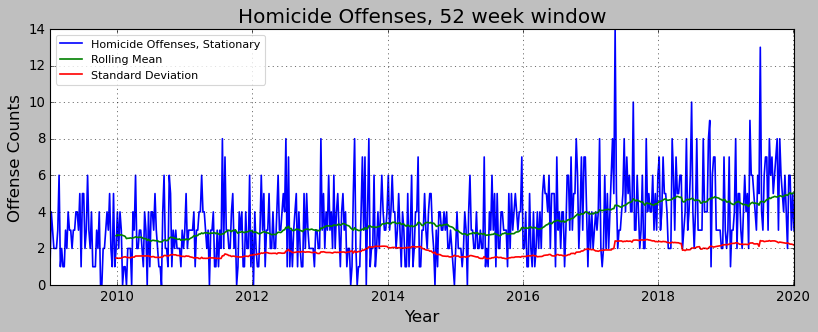

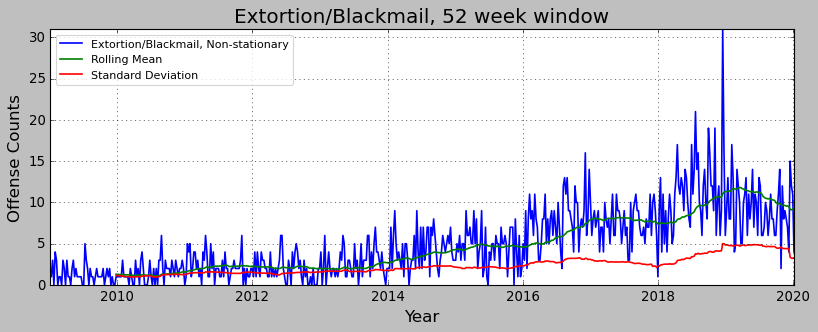

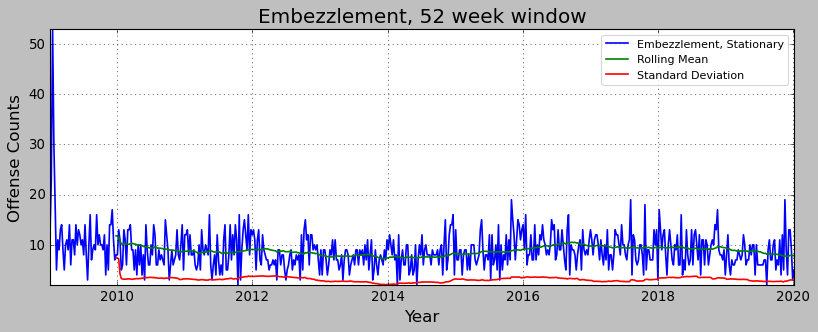

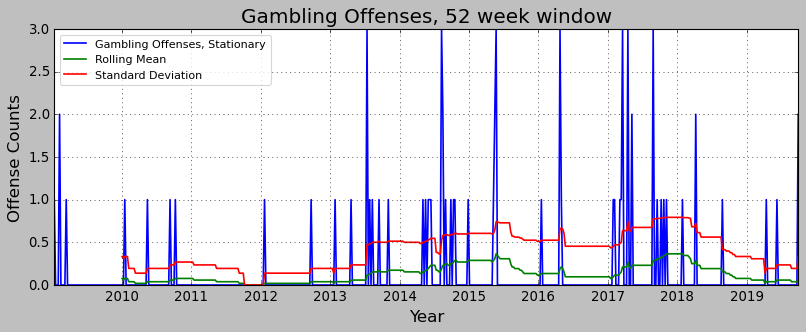

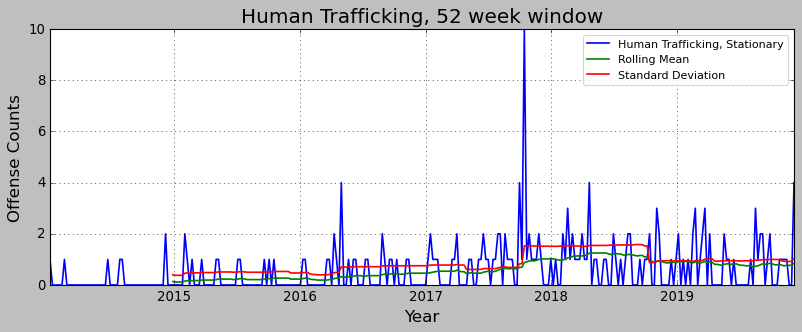

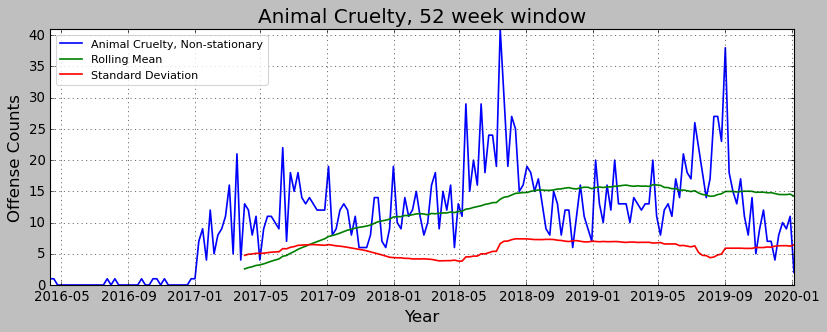

In [119]:
df_results1, ts_stationary1, ts_non_stationary_diff1=check_stationarity_multiple(TS_crime_category, window=52, plot=True)

In [120]:
df_results1

,Crime Category,Critical Value,P-value,Lags,Observations,"Critical value, 1%","Critical value, 5%","Critical value, 10%",Stationary?
Number,,,,,,,,,
1,Assault Offenses,-2.60387,0.0922002,13,561,-3.44206,-2.86671,-2.56952,False
2,Larceny/Theft Offenses,-2.3483,0.156864,6,568,-3.44192,-2.86664,-2.56949,False
3,Drug/Narcotic Offenses,-2.17551,0.215252,19,555,-3.44219,-2.86676,-2.56955,False
4,Fraud Offenses,-1.93097,0.317636,19,555,-3.44219,-2.86676,-2.56955,False
5,Destruction/Damage/Vandalism of Property,-4.37828,0.000324239,13,561,-3.44206,-2.86671,-2.56952,True
6,Burglary/Breaking & Entering,-3.82039,0.00270545,10,564,-3.442,-2.86668,-2.56951,True
7,Sex Offenses,-2.34786,0.156996,12,562,-3.44204,-2.8667,-2.56952,False
8,Arson,-7.87789,4.78917e-12,3,571,-3.44185,-2.86662,-2.56947,True
9,Motor Vehicle Theft,-1.51154,0.527797,5,569,-3.44189,-2.86663,-2.56948,False


<br><br><span style="font-size:1.2em; background:pink">There are **12** time-series that are already stationary and **11** that are not and which require additional processing (differencing).</span><br><br>
    
    

#### Differencing the time series that are not stationary

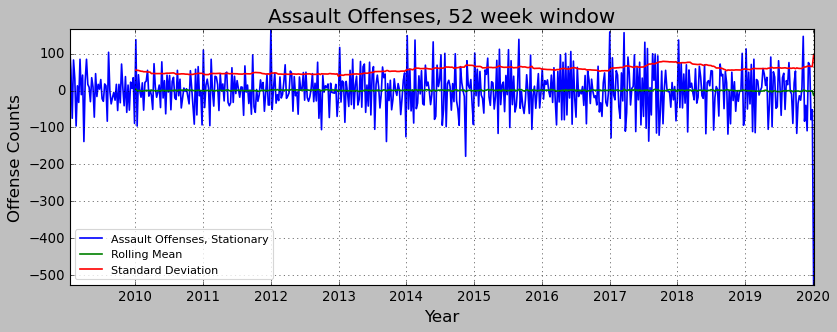

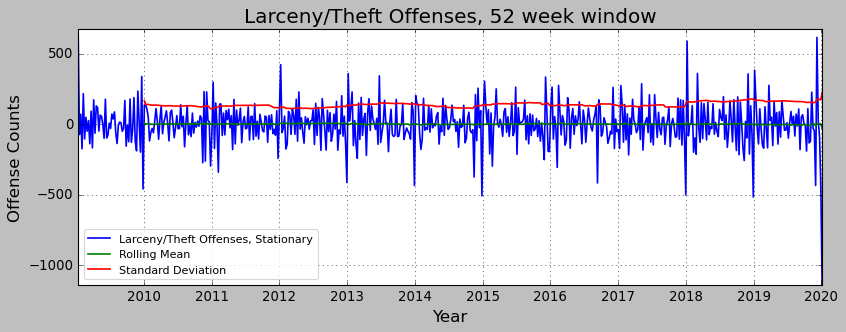

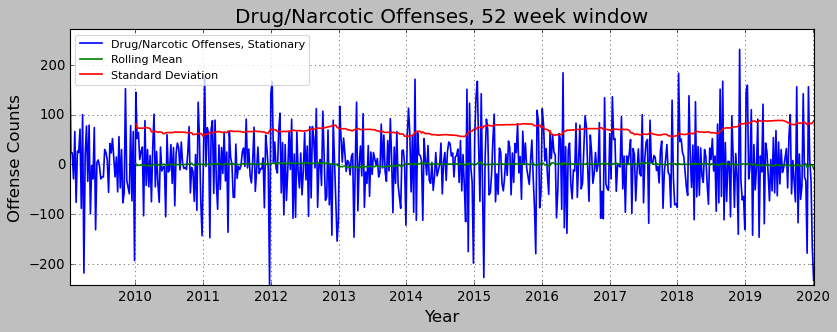

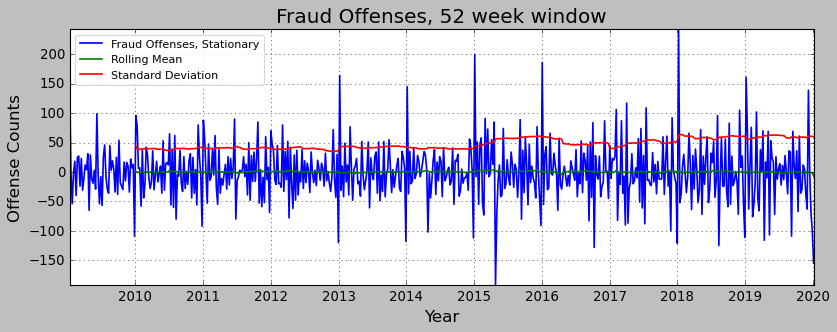

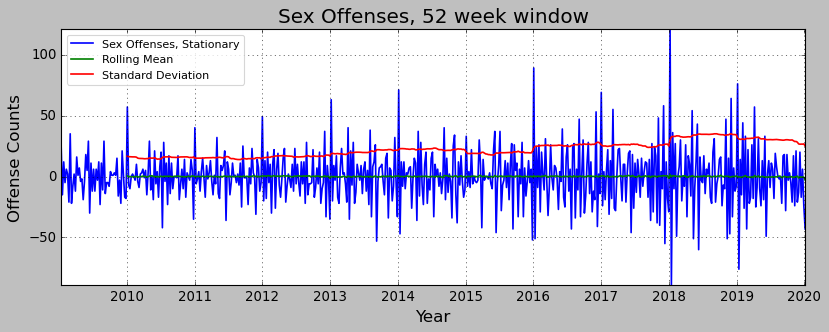

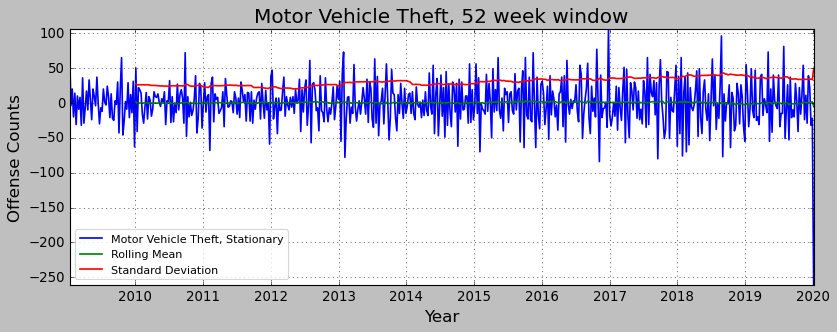

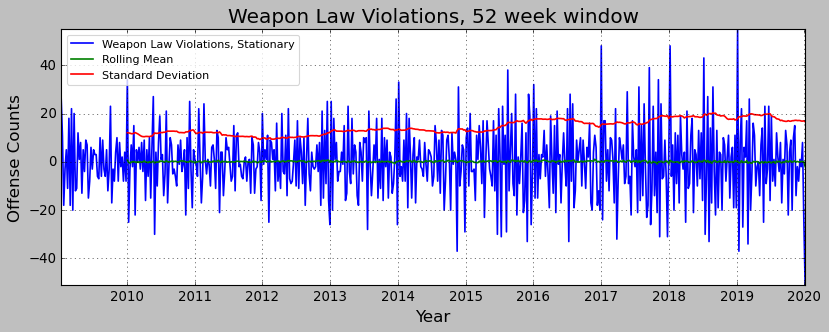

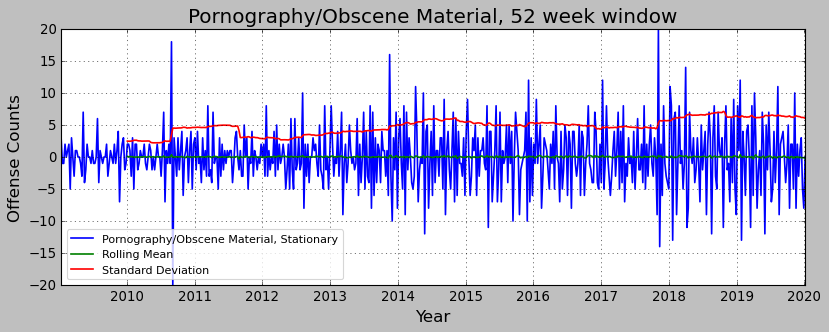

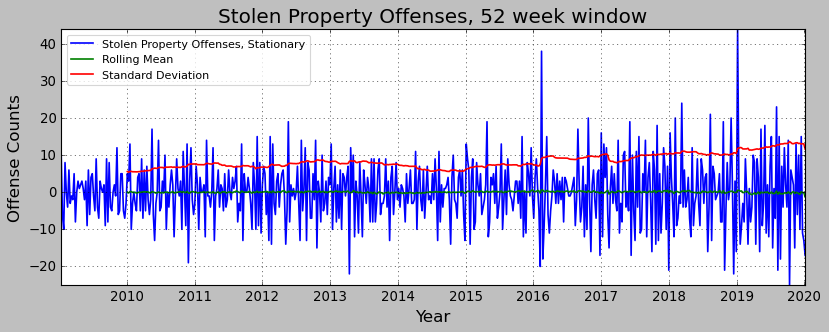

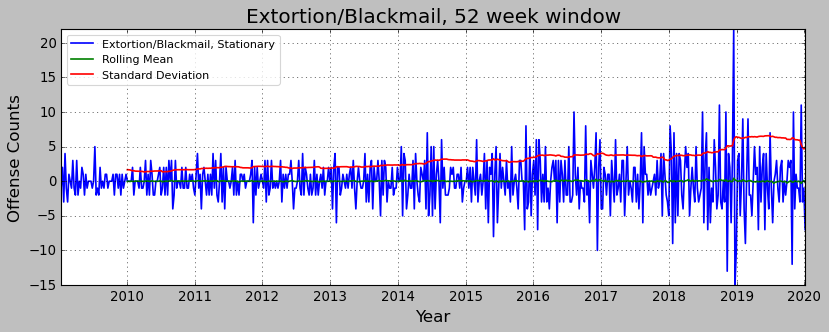

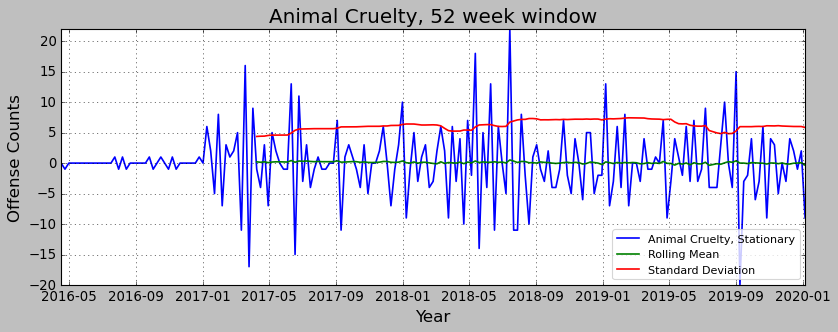

In [121]:

df_results2, ts_stationary2, ts_non_stationary_diff2=check_stationarity_multiple(ts_non_stationary_diff1, 
                                                                                  window=52, plot=True)

In [122]:
df_results2

,Crime Category,Critical Value,P-value,Lags,Observations,"Critical value, 1%","Critical value, 5%","Critical value, 10%",Stationary?
Number,,,,,,,,,
1,Assault Offenses,-8.87707,1.34899e-14,7,566,-3.44196,-2.86666,-2.5695,True
2,Larceny/Theft Offenses,-13.0153,2.5187e-24,5,568,-3.44192,-2.86664,-2.56949,True
3,Drug/Narcotic Offenses,-9.35728,7.99639e-16,19,554,-3.44221,-2.86677,-2.56956,True
4,Fraud Offenses,-7.71062,1.26672e-11,18,555,-3.44219,-2.86676,-2.56955,True
5,Sex Offenses,-9.50418,3.38186e-16,11,562,-3.44204,-2.8667,-2.56952,True
6,Motor Vehicle Theft,-14.781,2.24527e-27,4,569,-3.44189,-2.86663,-2.56948,True
7,Weapon Law Violations,-8.74384,2.95923e-14,15,558,-3.44212,-2.86673,-2.56954,True
8,Pornography/Obscene Material,-11.2016,2.23629e-20,9,564,-3.442,-2.86668,-2.56951,True
9,Stolen Property Offenses,-9.12419,3.14584e-15,17,556,-3.44217,-2.86675,-2.56955,True


<br><br><span style="font-size:1.2em; background:lightgreen">All **11** time-series got stationarized by the first dfferencing </span><br><br>
<span style="font-size:1.2em;">Theere are two separate dictionaries for offenses categories: one with 12 original time-series, that were stationary from the get go and another one with 11 time-series that were pre-processed with the first differencing.</span><br><br>
<span style="font-size:1.2em; background:lightblue">The next step is to explore ACFs and PACFs of the timeframe and make a decision on the pdq and PDQs orders.</span><br><br>


    

#### Exploring ACFs and PACFs of the originally stationary time-series

In [123]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

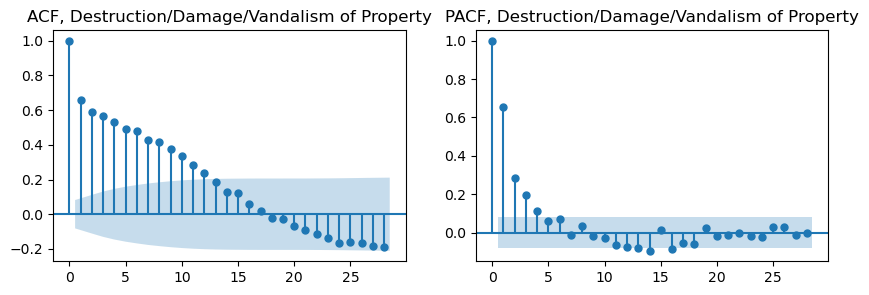

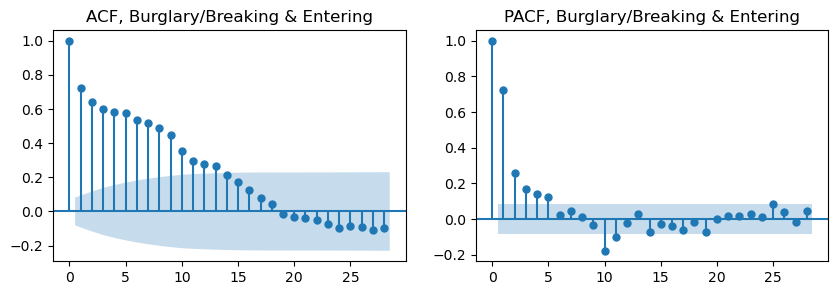

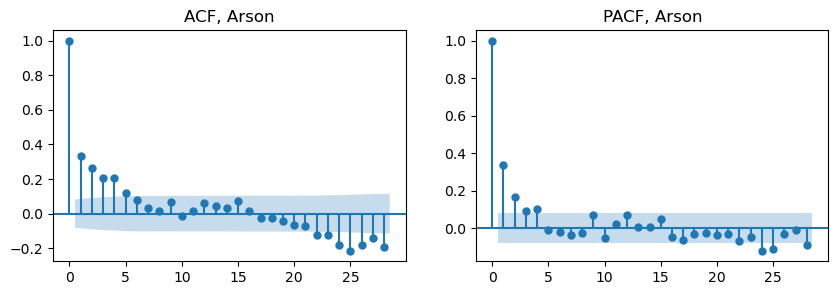

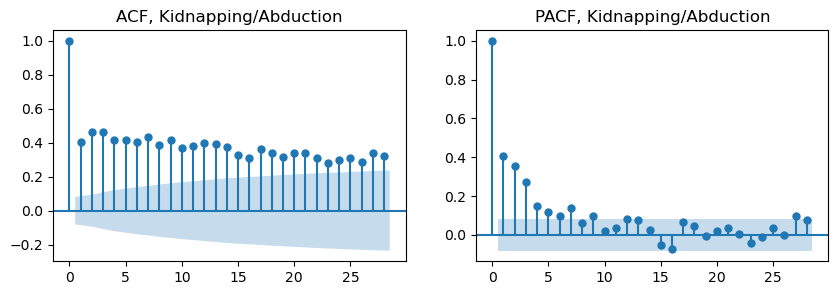

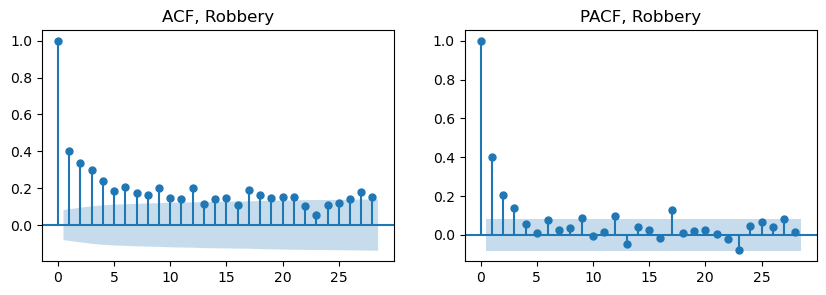

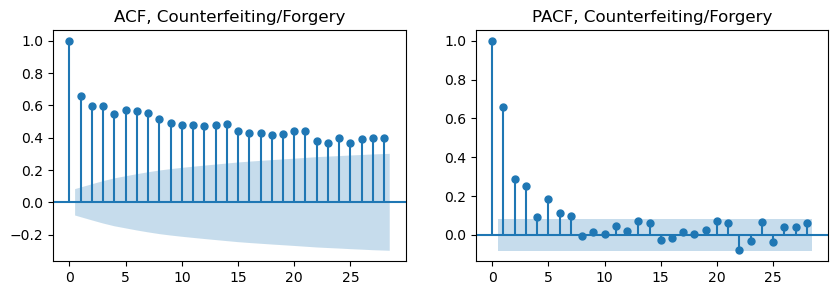

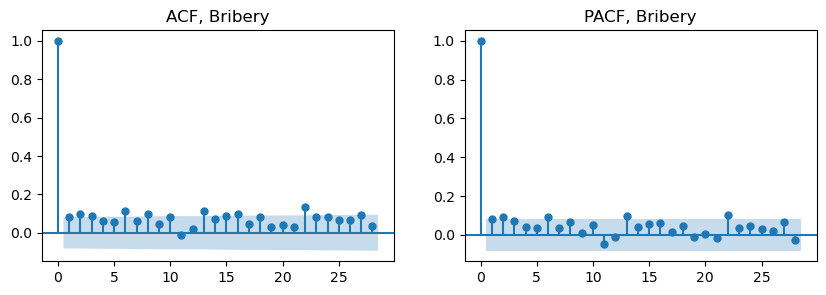

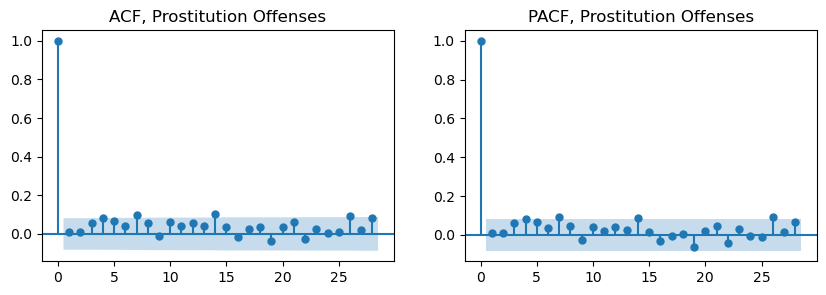

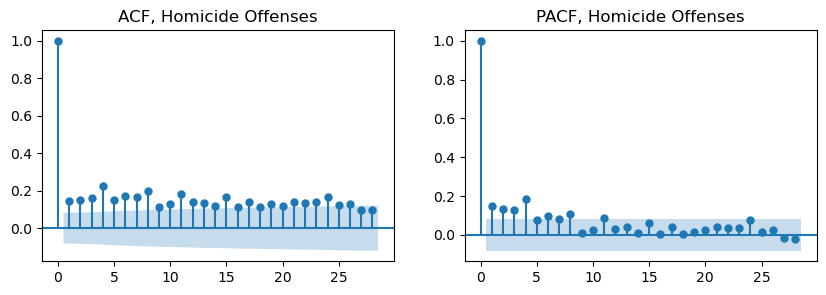

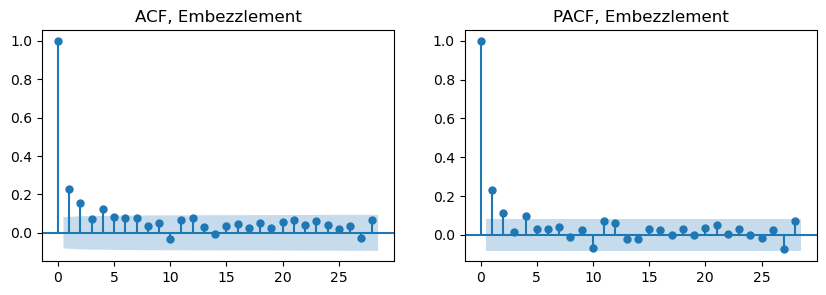

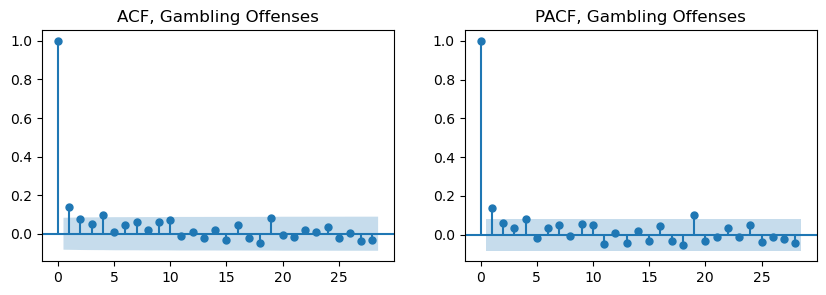

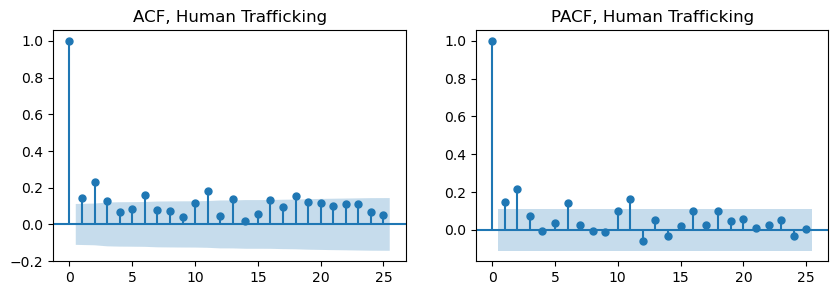

In [127]:
ACF_PACF_multiple(ts_stationary1)

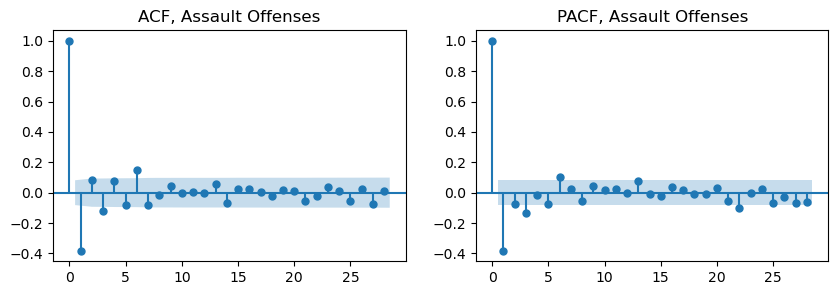

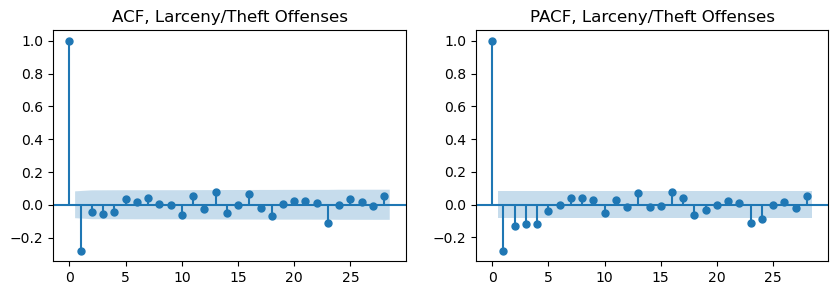

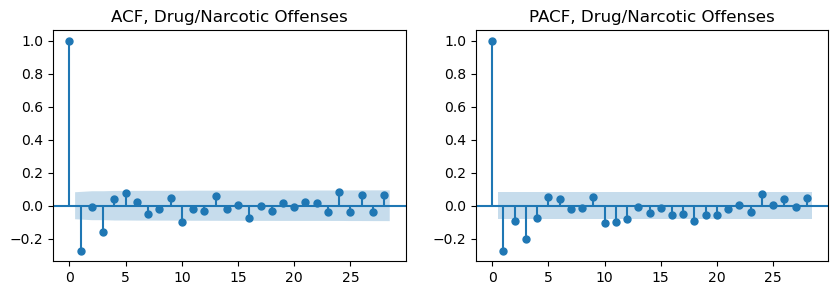

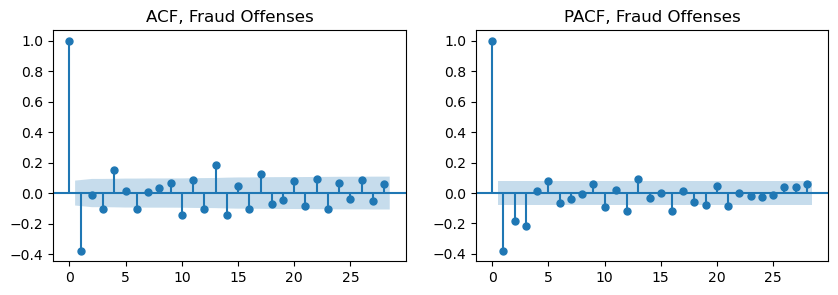

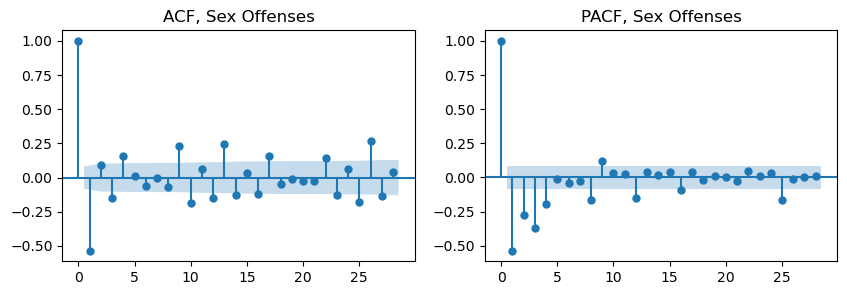

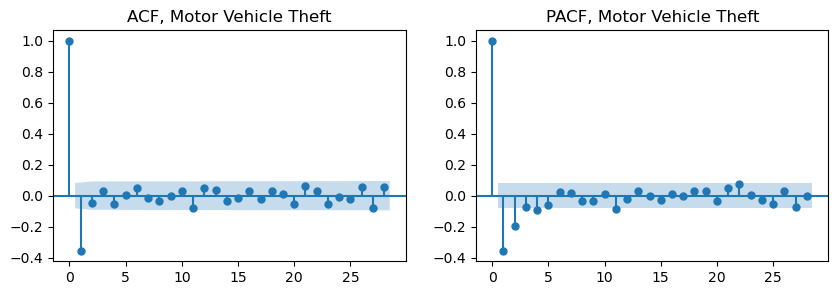

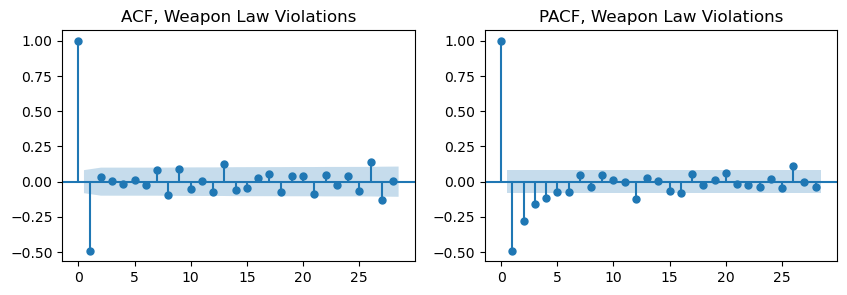

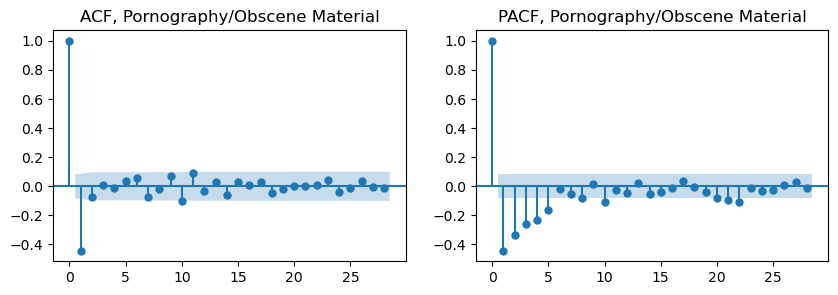

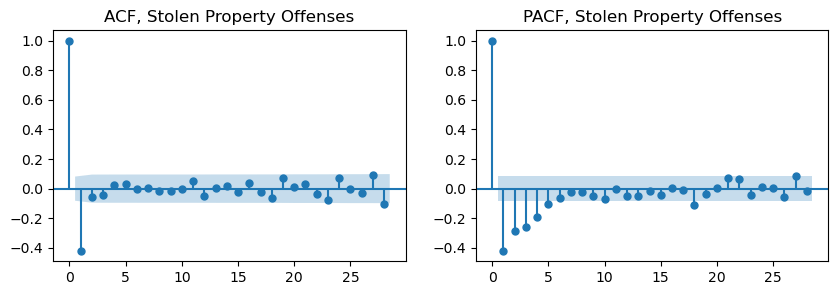

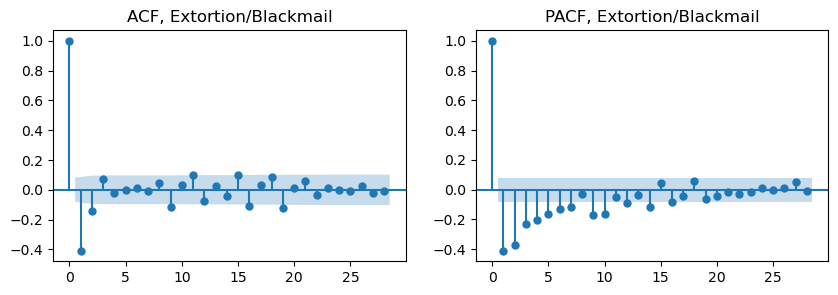

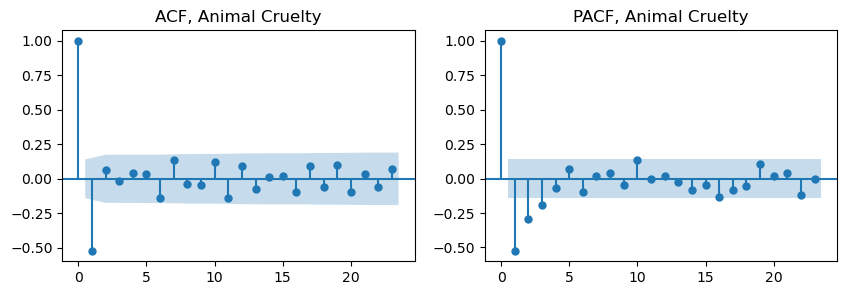

In [128]:
ACF_PACF_multiple(ts_stationary2)

# iNTERPRET

# CONCLUSIONS & RECOMMENDATIONS

> Summarize your conclusions and bullet-point your list of recommendations, which are based on your modeling results.

# TO DO/FUTURE WORK

- 